In [ ]:
!pip uninstall -y numpy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [ ]:
!pip install --no-cache-dir numpy==1.26.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 193.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.3 which is incompatible.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import numpy
numpy.__version__



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
save_path_videos = '/content/drive/MyDrive/paths/dataset_Videos.npy'
save_path_labels = '/content/drive/MyDrive/paths/dataset_labels.npy'

In [3]:
import numpy as np

videos = np.load(save_path_videos)
labels = np.load(save_path_labels)

In [4]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (4050, 22, 80, 112, 1)
Labels shape: (4050,)


In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode the labels into numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# One-hot encode the labels
labels_onehot = to_categorical(labels_encoded)

# Display the mapping
print("✅ Label encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

print("✅ Labels encoded and one-hot encoded.")


✅ Label encoding mapping:
0 → a
1 → bye
2 → can
3 → cat
4 → demo
5 → dog
6 → hello
7 → here
8 → is
9 → lips
10 → my
11 → read
12 → you
✅ Labels encoded and one-hot encoded.


In [6]:
label_dict = {0:"a", 1: "bye", 2:"can", 3:"cat", 4:"demo", 5:"dog", 6: "hello", 7:"here", 8:"is", 9:"lips", 10:"my", 11:"read", 12:"you"}

In [7]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    videos, labels_onehot, test_size=0.2, random_state=42, stratify=labels_encoded
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Training set: (3240, 22, 80, 112, 1), (3240, 13)
Validation set: (810, 22, 80, 112, 1), (810, 13)


In [8]:
del videos
del labels
del labels_encoded
del labels_onehot

In [9]:
import gc
gc.collect()
!cat /proc/meminfo | grep Mem


MemTotal:       13289424 kB
MemFree:         3335600 kB
MemAvailable:    8310236 kB


In [10]:
# =============================================================================
# 2. Temporal Convolutional Network (TCN) - Enhanced
# =============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class TCNBlock(layers.Layer):
    """Temporal Convolutional Network Block with dilated convolutions"""

    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.2, **kwargs):
        super(TCNBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.dropout_rate = dropout_rate

        # Dilated causal convolution
        self.conv1 = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal',
            activation='relu'
        )
        self.dropout1 = layers.Dropout(dropout_rate)
        self.norm1 = layers.LayerNormalization()

        # Second convolution
        self.conv2 = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal',
            activation='relu'
        )
        self.dropout2 = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization()

        # Residual connection adjustment
        self.residual_conv = layers.Conv1D(filters, 1) if filters != None else None

    def build(self, input_shape):
        super(TCNBlock, self).build(input_shape)
        # Adjust residual connection if needed
        if input_shape[-1] != self.filters:
            self.residual_conv = layers.Conv1D(self.filters, 1)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.dropout1(x, training=training)
        x = self.norm1(x)

        x = self.conv2(x)
        x = self.dropout2(x, training=training)
        x = self.norm2(x)

        # Residual connection
        if self.residual_conv:
            residual = self.residual_conv(inputs)
        else:
            residual = inputs

        return x + residual

def create_tcn_model(input_shape=(22, 64, 64, 3), num_classes=10):
    """
    Enhanced Temporal Convolutional Network for lip reading

    Args:
        input_shape: (sequence_length, height, width, channels)
        num_classes: Number of output classes
    """
    inputs = layers.Input(shape=input_shape)

    # CNN feature extraction per frame
    x = layers.TimeDistributed(
        layers.Conv2D(64, (3, 3), activation='relu', padding='same')
    )(inputs)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    x = layers.TimeDistributed(
        layers.Conv2D(128, (3, 3), activation='relu', padding='same')
    )(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)

    # Global average pooling to get feature vector per frame
    x = layers.TimeDistributed(layers.GlobalAveragePooling2D())(x)

    # TCN blocks with increasing dilation rates
    x = TCNBlock(filters=128, kernel_size=3, dilation_rate=1)(x)
    x = TCNBlock(filters=128, kernel_size=3, dilation_rate=2)(x)
    x = TCNBlock(filters=128, kernel_size=3, dilation_rate=4)(x)
    x = TCNBlock(filters=128, kernel_size=3, dilation_rate=8)(x)

    # Global temporal pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='TCN_LipReader')
    return model

# Example usage
print("=== Temporal Convolutional Network (TCN) ===")
tcn_model = create_tcn_model(input_shape=(22, 80, 112, 1), num_classes=13)
tcn_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
tcn_model.summary()
print()


=== Temporal Convolutional Network (TCN) ===


Model: "TCN_LipReader"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 22, 80, 112, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 22, 80, 112,    │           640 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 22, 40, 56, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 22, 40, 56,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 22, 20, 28,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 22, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block (TCNBlock)            │ (None, 22, 128)        │       115,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block_1 (TCNBlock)          │ (None, 22, 128)        │       115,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block_2 (TCNBlock)          │ (None, 22, 128)        │       115,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn_block_3 (TCNBlock)          │ (None, 22, 128)        │       115,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         3,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,197 (2.19 MB)

 Trainable params: 573,197 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

history = tcn_model.fit(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=8,
             callbacks=callbacks)

Epoch 1/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 72s 108ms/step - accuracy: 0.0759 - loss: 2.7297 - val_accuracy: 0.0753 - val_loss: 2.6251 - learning_rate: 1.0000e-04
Epoch 2/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 55s 82ms/step - accuracy: 0.0644 - loss: 2.6398 - val_accuracy: 0.0630 - val_loss: 2.6267 - learning_rate: 1.0000e-04
Epoch 3/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.0794 - loss: 2.6075 - val_accuracy: 0.0691 - val_loss: 2.5909 - learning_rate: 1.0000e-04
Epoch 4/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.0726 - loss: 2.5820 - val_accuracy: 0.0741 - val_loss: 2.5726 - learning_rate: 1.0000e-04
Epoch 5/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.0773 - loss: 2.5759 - val_accuracy: 0.0815 - val_loss: 2.5683 - learning_rate: 1.0000e-04
Epoch 6/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.0918 - loss: 2.5719 - val_accuracy: 0.0716 - val_loss: 2.5681 - learning_rate: 1.0000e-04
Epoch 7/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/st

In [13]:
def evaluate_model(model, name="Model"):
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"{name} - Validation Accuracy: {acc:.4f}, Loss: {loss:.4f}")

evaluate_model(tcn_model, "Temporal Convolutional Network ")



Temporal Convolutional Network  - Validation Accuracy: 0.0827, Loss: 2.5641


In [14]:
# Save the trained model
tcn_model.save("/content/drive/MyDrive/models/tcn.h5")
print("✅ Model saved.")


✅ Model saved.


In [16]:
y_pred_prob = tcn_model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 297ms/step


In [17]:
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Convert y_pred to one-hot encoded format to match y_val
y_pred_onehot = to_categorical(y_pred, num_classes=y_val.shape[1])

# Generate classification report
report = classification_report(y_val, y_pred_onehot, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-------+-----------+--------+----------+---------+
| Class | Precision | Recall | F1-Score | Support |
+-------+-----------+--------+----------+---------+
|   a   |    0.0    |  0.0   |   0.0    |   64.0  |
|  bye  |    0.1    |  0.19  |   0.13   |   62.0  |
|  can  |    0.0    |  0.0   |   0.0    |   61.0  |
|  cat  |    0.0    |  0.0   |   0.0    |   59.0  |
|  demo |    0.0    |  0.0   |   0.0    |   62.0  |
|  dog  |    0.0    |  0.0   |   0.0    |   60.0  |
| hello |    0.0    |  0.0   |   0.0    |   57.0  |
|  here |    0.0    |  0.0   |   0.0    |   66.0  |
|   is  |    0.07   |  0.03  |   0.04   |   65.0  |
|  lips |    0.0    |  0.0   |   0.0    |   64.0  |
|   my  |    0.0    |  0.0   |   0.0    |   64.0  |
|  read |    0.08   |  0.82  |   0.15   |   65.0  |
|  you  |    0.0    |  0.0   |   0.0    |   61.0  |
+-------+-----------+--------+----------+---------+


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


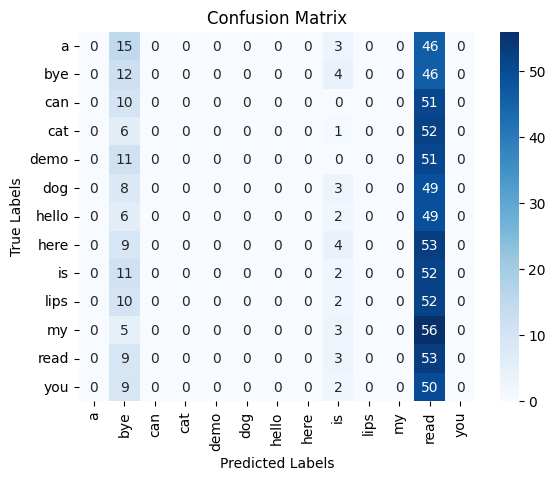

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

# Convert y_val to multiclass format
y_val_multiclass = np.argmax(y_val, axis=1)  # Convert one-hot to class indices

# Now generate the confusion matrix
conf_matrix = sklearn.metrics.confusion_matrix(y_val_multiclass, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

plot_training_history(history)
